<a href="https://colab.research.google.com/github/trantoai1/GraduatedProject/blob/main/Apply_Monodept.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Prepare


Clone and install requirements

In [ ]:
%cd /content/drive/MyDrive
!git clone https://github.com/nianticlabs/monodepth2.git

## get DB

In [ ]:
!wget -i splits/kitti_archives_to_download.txt -P kitti_data/

In [ ]:

#!wget https://repo.anaconda.com/archive/Anaconda3-2021.05-Linux-x86_64.sh

!rm -rf /content/drive/MyDrive/SSL/monodepth2/minicoda
!rmdir /content/drive/MyDrive/SSL/monodepth2/minicoda
!bash "Anaconda3-2021.05-Linux-x86_64.sh"


In [ ]:
%cd "/content/drive/MyDrive/SSL/anaconda3/"

# !bin/conda create -n monodepth2 python=3.6.6
!bin/activate monodepth2
# !bin/conda init --help
!bin/conda install opencv=3.3.1
!bin/conda install pytorch=0.4.1 torchvision=0.2.1 -c pytorch
!pip install tensorboardX==1.4

/content/drive/MyDrive/SSL/anaconda3
/bin/bash: bin/activate: /bin/sh: bad interpreter: Permission denied
/bin/bash: bin/conda: /content/drive/MyDrive/SSL/anaconda3/bin/python: bad interpreter: Permission denied
/bin/bash: bin/conda: /content/drive/MyDrive/SSL/anaconda3/bin/python: bad interpreter: Permission denied


In [ ]:
!pip uninstall numpy
!pip install numpy==1.16.0
import numpy as np
np.__version__

## Install requirement for train

In [ ]:
%cd /content/drive/MyDrive/SSL/monodepth2

/content/drive/MyDrive/SSL/monodepth2


In [ ]:
!python3.6 -m pip install torch==0.4.1

/usr/bin/python3.6: No module named pip


In [ ]:
!pip install scikit-image

In [ ]:
!pip install tensorboardX==1.4
# !pip uninstall torch torchvision
!pip install  torchvision==0.2.1
# !pip uninstall opencv-python
# !pip install opencv-python==3.4.0.14
!pip install numpy

     |████████████████████████████████| 67 kB 4.1 MB/s 
     |████████████████████████████████| 54 kB 2.8 MB/s 
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
fastai 1.0.61 requires torch>=1.0.0, but you have torch 0.4.1 which is incompatible.


In [ ]:
# !pip uninstall torch
# !wget https://files.pythonhosted.org/packages/d3/91/1b2871d6c8ca079254deae5872af32e02e9a85f07dd0834e8b3489ce138f/torch-0.4.1.post2-cp37-cp37m-manylinux1_x86_64.whl
#!pip install torch-0.4.1.post2-cp37-cp37m-manylinux1_x86_64.whl

Processing ./torch-0.4.1.post2-cp37-cp37m-manylinux1_x86_64.whl
  Attempting uninstall: torch
    Found existing installation: torch 0.4.1
    Uninstalling torch-0.4.1:
      Successfully uninstalled torch-0.4.1
ERROR: Operation cancelled by user


## install requirements for prunning

for z in *.zip; do unzip $z && rm $z; done

In [2]:
%cd /content/drive/MyDrive/SSL/monodepth2

/content/drive/MyDrive/SSL/monodepth2


In [3]:
!pip install tensorboardX==1.4

     |████████████████████████████████| 67 kB 3.1 MB/s 


## SSH


colab SSH

In [ ]:
#CODE

#Generate root password
import random, string
password = '220311To@i'

#Download ngrok
! wget -q -c -nc https://bin.equinox.io/c/4VmDzA7iaHb/ngrok-stable-linux-amd64.zip
! unzip -qq -n ngrok-stable-linux-amd64.zip
#Setup sshd
! apt-get install -qq -o=Dpkg::Use-Pty=0 openssh-server pwgen > /dev/null
#Set root password
! echo root:$password | chpasswd
! mkdir -p /var/run/sshd
! echo "PermitRootLogin yes" >> /etc/ssh/sshd_config
! echo "PasswordAuthentication yes" >> /etc/ssh/sshd_config
! echo "LD_LIBRARY_PATH=/usr/lib64-nvidia" >> /root/.bashrc
! echo "export LD_LIBRARY_PATH" >> /root/.bashrc

#Run sshd
get_ipython().system_raw('/usr/sbin/sshd -D &')

#Ask token
print("Copy authtoken from https://dashboard.ngrok.com/auth")
import getpass
authtoken = getpass.getpass()

#Create tunnel
get_ipython().system_raw('./ngrok authtoken $authtoken && ./ngrok tcp 22 &')
#Print root password
print("Root password: {}".format(password))
#Get public address
! curl -s http://localhost:4040/api/tunnels 
    
 # 21576NlyZe4EeWYvSrRLL5IzPoC_623rQ3hHZt6ciRgJvBGV2   

Copy authtoken from https://dashboard.ngrok.com/auth
··········
Root password: 220311To@i


# Test with cifar


In [ ]:
%cd /content/drive/MyDrive/SSL/rethinking-network-pruning/cifar/weight-level
!pip3 install progress

/content/drive/MyDrive/SSL/rethinking-network-pruning/cifar/weight-level
  Created wheel for progress: filename=progress-1.6-py3-none-any.whl size=9628 sha256=081df901e36285f1e67ba9471dbd5aa4520ec2d88da37c46bfccf6cf787d9d05
  Stored in directory: /root/.cache/pip/wheels/8e/d7/61/498d8e27dc11e9805b01eb3539e2ee344436fc226daeb5fe87
Successfully built progress


Pruning with optimized

In [ ]:
!python3 cifar_prune2.py --arch resnet --depth 20 --dataset cifar10 --percent 0.5 --resume results2/checkpoint.pth.tar --save_dir pruned2

==> Preparing dataset cifar10
Files already downloaded and verified
==> creating model 'resnet'
    Total params: 0.27M
==> Resuming from checkpoint..

Evaluation only
cifar_prune2.py:304: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
Processing |################################| (100/100) Data: 0.004s | Batch: 0.011s | Total: 0:00:01 | ETA: 0:00:01 | Loss: 0.3195 | top1:  92.2300 | top5:  99.7400
Before pruning: Test Loss:  0.31946984, Test Acc:  92.23
layer index: 2 	 total params: 432 	 remaining params: 289
layer index: 7 	 total params: 2304 	 remaining params: 1442
layer index: 10 	 total params: 2304 	 remaining params: 1516
layer index: 13 	 total params: 2304 	 remaining params: 1600
layer index: 16 	 total params: 2304 	 remaining params: 1597
layer index: 19 	 total params: 2304 	 remaining params: 1487
layer index: 22 	 total p

Pruning constant

In [ ]:
!python3 cifar_prune.py --arch resnet --depth 20 --dataset cifar10 --percent 0.5 --resume results2/checkpoint.pth.tar --save_dir pruned2

==> Preparing dataset cifar10
Files already downloaded and verified
==> creating model 'resnet'
    Total params: 0.27M
==> Resuming from checkpoint..

Evaluation only
cifar_prune.py:254: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  inputs, targets = torch.autograd.Variable(inputs, volatile=True), torch.autograd.Variable(targets)
Processing |################################| (100/100) Data: 0.004s | Batch: 0.014s | Total: 0:00:01 | ETA: 0:00:01 | Loss: 0.3195 | top1:  92.2300 | top5:  99.7400
Before pruning: Test Loss:  0.31946984, Test Acc:  92.23
Pruning threshold: 0.05572894588112831
layer index: 2 	 total params: 432 	 remaining params: 353
layer index: 7 	 total params: 2304 	 remaining params: 1443
layer index: 10 	 total params: 2304 	 remaining params: 1562
layer index: 13 	 total params: 2304 	 remaining params: 1388
layer index: 16 	 total params: 2304 	 remaining params: 1384
layer index: 19 	 total params: 2304 	 remaining 

# Test with monodepth


##Options


In [4]:
%cd /content/drive/MyDrive/SSL/monodepth2

/content/drive/MyDrive/SSL/monodepth2


In [29]:
# Copyright Niantic 2019. Patent Pending. All rights reserved.
#
# This software is licensed under the terms of the Monodepth2 licence
# which allows for non-commercial use only, the full terms of which are made
# available in the LICENSE file.

from __future__ import absolute_import, division, print_function

import os
import argparse


import numpy as np
import time

import torch
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader
from tensorboardX import SummaryWriter

import json
from utils import AverageMeter
from utils import *
from kitti_utils import *
from layers import *
import datasets
import networks
from IPython import embed

file_dir = '/content/drive/MyDrive/SSL/monodepth2/'  # the directory that options.py resides in


class MonodepthOptions:
    def __init__(self):
        self.parser = argparse.ArgumentParser(description="Monodepthv2 options")

        # PATHS
        self.parser.add_argument("--data_path",
                                 type=str,
                                 help="path to the training data",
                                 default=os.path.join(file_dir, "kitti_data"))
        self.parser.add_argument("--log_dir",
                                 type=str,
                                 help="log directory",
                                 default='newmodel')

        # TRAINING options
        self.parser.add_argument("--model_name",
                                 type=str,
                                 help="the name of the folder to save the model in",
                                 default="newmodel/mono_model/models/weights_3")
        self.parser.add_argument("--split",
                                 type=str,
                                 help="which training split to use",
                                 choices=["eigen_zhou", "eigen_full", "odom", "benchmark"],
                                 default="eigen_zhou")
        self.parser.add_argument("--num_layers",
                                 type=int,
                                 help="number of resnet layers",
                                 default=18,
                                 choices=[18, 34, 50, 101, 152])
        self.parser.add_argument("--dataset",
                                 type=str,
                                 help="dataset to train on",
                                 default="kitti",
                                 choices=["kitti", "kitti_odom", "kitti_depth", "kitti_test"])
        self.parser.add_argument("--png",
                                 help="if set, trains from raw KITTI png files (instead of jpgs)",
                                 action="store_true")
        self.parser.add_argument("--height",
                                 type=int,
                                 help="input image height",
                                 default=192)
        self.parser.add_argument("--width",
                                 type=int,
                                 help="input image width",
                                 default=640)
        self.parser.add_argument("--disparity_smoothness",
                                 type=float,
                                 help="disparity smoothness weight",
                                 default=1e-3)
        self.parser.add_argument("--scales",
                                 nargs="+",
                                 type=int,
                                 help="scales used in the loss",
                                 default=[0, 1, 2, 3])
        self.parser.add_argument("--min_depth",
                                 type=float,
                                 help="minimum depth",
                                 default=0.1)
        self.parser.add_argument("--max_depth",
                                 type=float,
                                 help="maximum depth",
                                 default=100.0)
        self.parser.add_argument("--use_stereo",
                                 help="if set, uses stereo pair for training",
                                 action="store_true")
        self.parser.add_argument("--frame_ids",
                                 nargs="+",
                                 type=int,
                                 help="frames to load",
                                 default=[0, -1, 1])

        # OPTIMIZATION options
        self.parser.add_argument("--batch_size",
                                 type=int,
                                 help="batch size",
                                 default=12)
        self.parser.add_argument("--learning_rate",
                                 type=float,
                                 help="learning rate",
                                 default=1e-4)
        self.parser.add_argument("--num_epochs",
                                 type=int,
                                 help="number of epochs",
                                 default=20)
        self.parser.add_argument("--scheduler_step_size",
                                 type=int,
                                 help="step size of the scheduler",
                                 default=15)

        # ABLATION options
        self.parser.add_argument("--v1_multiscale",
                                 help="if set, uses monodepth v1 multiscale",
                                 action="store_true")
        self.parser.add_argument("--avg_reprojection",
                                 help="if set, uses average reprojection loss",
                                 action="store_true")
        self.parser.add_argument("--disable_automasking",
                                 help="if set, doesn't do auto-masking",
                                 action="store_true")
        self.parser.add_argument("--predictive_mask",
                                 help="if set, uses a predictive masking scheme as in Zhou et al",
                                 action="store_true")
        self.parser.add_argument("--no_ssim",
                                 help="if set, disables ssim in the loss",
                                 action="store_true")
        self.parser.add_argument("--weights_init",
                                 type=str,
                                 help="pretrained or scratch",
                                 default="pretrained",
                                 choices=["pretrained", "scratch"])
        self.parser.add_argument("--pose_model_input",
                                 type=str,
                                 help="how many images the pose network gets",
                                 default="pairs",
                                 choices=["pairs", "all"])
        self.parser.add_argument("--pose_model_type",
                                 type=str,
                                 help="normal or shared",
                                 default="separate_resnet",
                                 choices=["posecnn", "separate_resnet", "shared"])

        # SYSTEM options
        self.parser.add_argument("--no_cuda",
                                 help="if set disables CUDA",
                                 action="store_true")
        self.parser.add_argument("--num_workers",
                                 type=int,
                                 help="number of dataloader workers",
                                 default=1)

        # LOADING options
        self.parser.add_argument("--load_weights_folder",
                                 type=str,
                                 help="name of model to load",
                                 default="newmodel/mono_model/models/weights_3")
        self.parser.add_argument("--models_to_load",
                                 nargs="+",
                                 type=str,
                                 help="models to load",
                                 default=["encoder", "depth"])

        # LOGGING options
        self.parser.add_argument("--log_frequency",
                                 type=int,
                                 help="number of batches between each tensorboard log",
                                 default=250)
        self.parser.add_argument("--save_frequency",
                                 type=int,
                                 help="number of epochs between each save",
                                 default=1)

        # EVALUATION options
        self.parser.add_argument("--eval_stereo",
                                 help="if set evaluates in stereo mode",
                                 action="store_true")
        self.parser.add_argument("--eval_mono",
                                 help="if set evaluates in mono mode",
                                 action="store_true")
        self.parser.add_argument("--disable_median_scaling",
                                 help="if set disables median scaling in evaluation",
                                 action="store_true")
        self.parser.add_argument("--pred_depth_scale_factor",
                                 help="if set multiplies predictions by this number",
                                 type=float,
                                 default=1)
        self.parser.add_argument("--ext_disp_to_eval",
                                 type=str,
                                 help="optional path to a .npy disparities file to evaluate")
        self.parser.add_argument("--eval_split",
                                 type=str,
                                 default="eigen",
                                 choices=[
                                    "eigen", "eigen_benchmark", "benchmark", "odom_9", "odom_10"],
                                 help="which split to run eval on")
        self.parser.add_argument("--save_pred_disps",
                                 help="if set saves predicted disparities",
                                 action="store_true")
        self.parser.add_argument("--no_eval",
                                 help="if set disables evaluation",
                                 action="store_true")
        self.parser.add_argument("--eval_eigen_to_benchmark",
                                 help="if set assume we are loading eigen results from npy but "
                                      "we want to evaluate using the new benchmark.",
                                 action="store_true")
        self.parser.add_argument("--eval_out_dir",
                                 help="if set will output the disparities to this folder",
                                 type=str)
        self.parser.add_argument("--post_process",
                                 help="if set will perform the flipping post processing "
                                      "from the original monodepth paper",
                                 action="store_true")
        self.parser.add_argument("--density",
                                 help="threshold create mask",
                                 type=float,
                                 default=0.05)
        self.parser.add_argument('--schedule', type=int, nargs='+', default=[8, 12],
                        help='Decrease learning rate at these epochs.')
        self.parser.add_argument('--gamma', type=float, default=0.1, help='LR is multiplied by gamma on schedule.')
        self.parser.add_argument('--lr', '--learning-rate', default=1e-4, type=float,
                        metavar='LR', help='initial learning rate')

        self.parser.add_argument('--momentum', default=0.9, type=float, metavar='M',
                            help='momentum')

        self.parser.add_argument('--weight-decay', '--wd', default=5.0e-4, type=float,
                            metavar='W', help='weight decay (default: 1e-4)')
        self.parser.add_argument('--image_path', type=str,
                        help='path to a test image or folder of images')
        self.parser.add_argument('--percent', default=0.5, type=float, help='percentage of weight to prune')

    def parse(self):
        self.options = self.parser.parse_args(args=[])
        return self.options


In [30]:

options = MonodepthOptions()

opts = options.parse()

state = {k: v for k, v in opts._get_kwargs()}

In [7]:
import datasets
datasets_dict = {"kitti": datasets.KITTIRAWDataset,
                         "kitti_odom": datasets.KITTIOdomDataset}
dataset = datasets_dict['kitti']

fpath = os.path.join(os.path.dirname(file_dir), "splits", opts.split, "{}_files.txt")

train_filenames = readlines(fpath.format("train"))
val_filenames = readlines(fpath.format("val"))
img_ext = '.png'
num_train_samples = len(train_filenames)
num_total_steps = num_train_samples // opts.batch_size * opts.num_epochs

train_dataset = dataset(
    opts.data_path, train_filenames, opts.height, opts.width,
    opts.frame_ids, 4, is_train=True, img_ext=img_ext)
train_loader = DataLoader(
    train_dataset, opts.batch_size, True,
    num_workers=opts.num_workers, pin_memory=True, drop_last=True)
val_dataset = dataset(
    opts.data_path, val_filenames, opts.height, opts.width,
    opts.frame_ids, 4, is_train=False, img_ext=img_ext)
val_loader = DataLoader(
    val_dataset, opts.batch_size, True,
    num_workers=opts.num_workers, pin_memory=True, drop_last=True)


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


## Trainer

Class Trainer

In [16]:
import math
class Trainer:
    def __init__(self, options, train_loader=None, val_loader=None):
        self.opt = options
        self.log_path = os.path.join(self.opt.log_dir, self.opt.model_name)

        # checking height and width are multiples of 32
        assert self.opt.height % 32 == 0, "'height' must be a multiple of 32"
        assert self.opt.width % 32 == 0, "'width' must be a multiple of 32"

        self.models = {}
        self.parameters_to_train = []
        self.epoch = 0
        self.step = 0
        self.start_time = time.time()
        self.device = torch.device("cpu" if self.opt.no_cuda else "cuda")

        self.num_scales = len(self.opt.scales)
        self.num_input_frames = len(self.opt.frame_ids)
        self.num_pose_frames = 2 if self.opt.pose_model_input == "pairs" else self.num_input_frames

        assert self.opt.frame_ids[0] == 0, "frame_ids must start with 0"

        self.use_pose_net = not (self.opt.use_stereo and self.opt.frame_ids == [0])

        if self.opt.use_stereo:
            self.opt.frame_ids.append("s")

        self.models["encoder"] = networks.ResnetEncoder(
            self.opt.num_layers, self.opt.weights_init == "pretrained")
        self.models["encoder"].to(self.device)
        self.parameters_to_train += list(self.models["encoder"].parameters())
        self.models["depth"] = networks.DepthDecoder(
            self.models["encoder"].num_ch_enc, self.opt.scales)
        self.models["depth"].to(self.device)
        self.parameters_to_train += list(self.models["depth"].parameters())

        if self.use_pose_net:
            if self.opt.pose_model_type == "separate_resnet":
                self.models["pose_encoder"] = networks.ResnetEncoder(
                    self.opt.num_layers,
                    self.opt.weights_init == "pretrained",
                    num_input_images=self.num_pose_frames)

                self.models["pose_encoder"].to(self.device)
                self.parameters_to_train += list(self.models["pose_encoder"].parameters())

                self.models["pose"] = networks.PoseDecoder(
                    self.models["pose_encoder"].num_ch_enc,
                    num_input_features=1,
                    num_frames_to_predict_for=2)

            elif self.opt.pose_model_type == "shared":
                self.models["pose"] = networks.PoseDecoder(
                    self.models["encoder"].num_ch_enc, self.num_pose_frames)

            elif self.opt.pose_model_type == "posecnn":
                self.models["pose"] = networks.PoseCNN(
                    self.num_input_frames if self.opt.pose_model_input == "all" else 2)

            self.models["pose"].to(self.device)
            self.parameters_to_train += list(self.models["pose"].parameters())

        if self.opt.predictive_mask:
            assert self.opt.disable_automasking, \
                "When using predictive_mask, please disable automasking with --disable_automasking"

            # Our implementation of the predictive masking baseline has the the same architecture
            # as our depth decoder. We predict a separate mask for each source frame.
            self.models["predictive_mask"] = networks.DepthDecoder(
                self.models["encoder"].num_ch_enc, self.opt.scales,
                num_output_channels=(len(self.opt.frame_ids) - 1))
            self.models["predictive_mask"].to(self.device)
            self.parameters_to_train += list(self.models["predictive_mask"].parameters())

        self.model_optimizer = optim.SGD(self.parameters_to_train, lr=self.opt.lr, momentum=self.opt.momentum, weight_decay=self.opt.weight_decay)
        #self.model_optimizer = optim.Adam(self.parameters_to_train, self.opt.learning_rate)

        self.model_lr_scheduler = optim.lr_scheduler.StepLR(
            self.model_optimizer, self.opt.scheduler_step_size, 0.1)

        print("Training model named:\n  ", self.opt.model_name)
        print("Models and tensorboard events files are saved to:\n  ", self.opt.log_dir)
        print("Training is using:\n  ", self.device)

        # data
        datasets_dict = {"kitti": datasets.KITTIRAWDataset,
                         "kitti_odom": datasets.KITTIOdomDataset}
        self.dataset = datasets_dict[self.opt.dataset]

        fpath = os.path.join(os.path.dirname(file_dir), "splits", self.opt.split, "{}_files.txt")

        train_filenames = readlines(fpath.format("train"))
        val_filenames = readlines(fpath.format("val"))
        img_ext = '.png' if self.opt.png else '.jpg'

        num_train_samples = len(train_filenames)
        self.num_total_steps = num_train_samples // self.opt.batch_size * self.opt.num_epochs

        train_dataset = self.dataset(
            self.opt.data_path, train_filenames, self.opt.height, self.opt.width,
            self.opt.frame_ids, 4, is_train=True, img_ext=img_ext)
        if train_loader is None:
            self.train_loader = DataLoader(
                train_dataset, self.opt.batch_size, True,
                num_workers=self.opt.num_workers, pin_memory=True, drop_last=True)
        else:
            self.train_loader = train_loader
        val_dataset = self.dataset(
            self.opt.data_path, val_filenames, self.opt.height, self.opt.width,
            self.opt.frame_ids, 4, is_train=False, img_ext=img_ext)
        if val_loader is None:
            self.val_loader = DataLoader(
                val_dataset, self.opt.batch_size, True,
                num_workers=self.opt.num_workers, pin_memory=True, drop_last=True)
        else:
            self.val_loader = val_loader
        self.val_iter = iter(self.val_loader)
        if self.opt.load_weights_folder is not None:
            self.load_model()
        self.writers = {}
        for mode in ["train", "val"]:
            self.writers[mode] = SummaryWriter(os.path.join(self.log_path, mode))

        if not self.opt.no_ssim:
            self.ssim = SSIM()
            self.ssim.to(self.device)

        self.backproject_depth = {}
        self.project_3d = {}
        for scale in self.opt.scales:
            h = self.opt.height // (2 ** scale)
            w = self.opt.width // (2 ** scale)

            self.backproject_depth[scale] = BackprojectDepth(self.opt.batch_size, h, w)
            self.backproject_depth[scale].to(self.device)

            self.project_3d[scale] = Project3D(self.opt.batch_size, h, w)
            self.project_3d[scale].to(self.device)

        self.depth_metric_names = [
            "de/abs_rel", "de/sq_rel", "de/rms", "de/log_rms", "da/a1", "da/a2", "da/a3"]

        print("Using split:\n  ", self.opt.split)
        print("There are {:d} training items and {:d} validation items\n".format(
            len(train_dataset), len(val_dataset)))

        self.save_opts()

    def set_train(self):
        """Convert all models to training mode
        """
        for m in self.models.values():
            m.train()

    def set_eval(self):
        """Convert all models to testing/evaluation mode
        """
        for m in self.models.values():
            m.eval()

    def train(self):
        """Run the entire training pipeline
        """
        self.epoch = 0
        self.step = 0
        self.start_time = time.time()
        for self.epoch in range(self.opt.num_epochs):
            self.run_epoch()
            if (self.epoch + 1) % self.opt.save_frequency == 0:
                self.save_model()

    def run_epoch(self):
        """Run a single epoch of training and validation
        """
        self.model_lr_scheduler.step()

        print("Training")
        self.set_train()

        for batch_idx, inputs in enumerate(self.train_loader):
            print('index ', batch_idx)
            before_op_time = time.time()

            outputs, losses = self.process_batch(inputs)

            self.model_optimizer.zero_grad()
            losses["loss"].backward()
            self.model_optimizer.step()

            duration = time.time() - before_op_time

            # log less frequently after the first 2000 steps to save time & disk space
            early_phase = batch_idx % self.opt.log_frequency == 0 and self.step < 2000
            late_phase = self.step % 2000 == 0

            if early_phase or late_phase:
                self.log_time(batch_idx, duration, losses["loss"].cpu().data)

                if "depth_gt" in inputs:
                    self.compute_depth_losses(inputs, outputs, losses)

                self.log("train", inputs, outputs, losses)
                self.val()

            self.step += 1

    def process_batch(self, inputs):
        """Pass a minibatch through the network and generate images and losses
        """
        for key, ipt in inputs.items():
            inputs[key] = ipt.to(self.device)

        if self.opt.pose_model_type == "shared":
            # If we are using a shared encoder for both depth and pose (as advocated
            # in monodepthv1), then all images are fed separately through the depth encoder.
            all_color_aug = torch.cat([inputs[("color_aug", i, 0)] for i in self.opt.frame_ids])
            all_features = self.models["encoder"](all_color_aug)
            all_features = [torch.split(f, self.opt.batch_size) for f in all_features]

            features = {}
            for i, k in enumerate(self.opt.frame_ids):
                features[k] = [f[i] for f in all_features]

            outputs = self.models["depth"](features[0])
        else:
            # Otherwise, we only feed the image with frame_id 0 through the depth encoder
            features = self.models["encoder"](inputs["color_aug", 0, 0])
            outputs = self.models["depth"](features)

        if self.opt.predictive_mask:
            outputs["predictive_mask"] = self.models["predictive_mask"](features)

        if self.use_pose_net:
            outputs.update(self.predict_poses(inputs, features))

        self.generate_images_pred(inputs, outputs)
        losses = self.compute_losses(inputs, outputs)

        return outputs, losses

    def predict_poses(self, inputs, features):
        """Predict poses between input frames for monocular sequences.
        """
        outputs = {}
        if self.num_pose_frames == 2:
            # In this setting, we compute the pose to each source frame via a
            # separate forward pass through the pose network.

            # select what features the pose network takes as input
            if self.opt.pose_model_type == "shared":
                pose_feats = {f_i: features[f_i] for f_i in self.opt.frame_ids}
            else:
                pose_feats = {f_i: inputs["color_aug", f_i, 0] for f_i in self.opt.frame_ids}

            for f_i in self.opt.frame_ids[1:]:
                if f_i != "s":
                    # To maintain ordering we always pass frames in temporal order
                    if f_i < 0:
                        pose_inputs = [pose_feats[f_i], pose_feats[0]]
                    else:
                        pose_inputs = [pose_feats[0], pose_feats[f_i]]

                    if self.opt.pose_model_type == "separate_resnet":
                        pose_inputs = [self.models["pose_encoder"](torch.cat(pose_inputs, 1))]
                    elif self.opt.pose_model_type == "posecnn":
                        pose_inputs = torch.cat(pose_inputs, 1)

                    axisangle, translation = self.models["pose"](pose_inputs)
                    outputs[("axisangle", 0, f_i)] = axisangle
                    outputs[("translation", 0, f_i)] = translation

                    # Invert the matrix if the frame id is negative
                    outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(
                        axisangle[:, 0], translation[:, 0], invert=(f_i < 0))

        else:
            # Here we input all frames to the pose net (and predict all poses) together
            if self.opt.pose_model_type in ["separate_resnet", "posecnn"]:
                pose_inputs = torch.cat(
                    [inputs[("color_aug", i, 0)] for i in self.opt.frame_ids if i != "s"], 1)

                if self.opt.pose_model_type == "separate_resnet":
                    pose_inputs = [self.models["pose_encoder"](pose_inputs)]

            elif self.opt.pose_model_type == "shared":
                pose_inputs = [features[i] for i in self.opt.frame_ids if i != "s"]

            axisangle, translation = self.models["pose"](pose_inputs)

            for i, f_i in enumerate(self.opt.frame_ids[1:]):
                if f_i != "s":
                    outputs[("axisangle", 0, f_i)] = axisangle
                    outputs[("translation", 0, f_i)] = translation
                    outputs[("cam_T_cam", 0, f_i)] = transformation_from_parameters(
                        axisangle[:, i], translation[:, i])

        return outputs

    def generate_images_pred(self, inputs, outputs):
        """Generate the warped (reprojected) color images for a minibatch.
        Generated images are saved into the `outputs` dictionary.
        """
        for scale in self.opt.scales:
            disp = outputs[("disp", scale)]
            if self.opt.v1_multiscale:
                source_scale = scale
            else:
                disp = F.interpolate(
                    disp, [self.opt.height, self.opt.width], mode="bilinear", align_corners=False)
                source_scale = 0

            _, depth = disp_to_depth(disp, self.opt.min_depth, self.opt.max_depth)

            outputs[("depth", 0, scale)] = depth

            for i, frame_id in enumerate(self.opt.frame_ids[1:]):

                if frame_id == "s":
                    T = inputs["stereo_T"]
                else:
                    T = outputs[("cam_T_cam", 0, frame_id)]

                # from the authors of https://arxiv.org/abs/1712.00175
                if self.opt.pose_model_type == "posecnn":
                    axisangle = outputs[("axisangle", 0, frame_id)]
                    translation = outputs[("translation", 0, frame_id)]

                    inv_depth = 1 / depth
                    mean_inv_depth = inv_depth.mean(3, True).mean(2, True)

                    T = transformation_from_parameters(
                        axisangle[:, 0], translation[:, 0] * mean_inv_depth[:, 0], frame_id < 0)

                cam_points = self.backproject_depth[source_scale](
                    depth, inputs[("inv_K", source_scale)])
                pix_coords = self.project_3d[source_scale](
                    cam_points, inputs[("K", source_scale)], T)

                outputs[("sample", frame_id, scale)] = pix_coords

                outputs[("color", frame_id, scale)] = F.grid_sample(
                    inputs[("color", frame_id, source_scale)],
                    outputs[("sample", frame_id, scale)],
                    padding_mode="border")

                if not self.opt.disable_automasking:
                    outputs[("color_identity", frame_id, scale)] = \
                        inputs[("color", frame_id, source_scale)]

    def compute_reprojection_loss(self, pred, target):
        """Computes reprojection loss between a batch of predicted and target images
        """
        abs_diff = torch.abs(target - pred)
        l1_loss = abs_diff.mean(1, True)

        if self.opt.no_ssim:
            reprojection_loss = l1_loss
        else:
            ssim_loss = self.ssim(pred, target).mean(1, True)
            reprojection_loss = 0.85 * ssim_loss + 0.15 * l1_loss

        return reprojection_loss

    def compute_losses(self, inputs, outputs):
        """Compute the reprojection and smoothness losses for a minibatch
        """
        losses = {}
        total_loss = 0

        for scale in self.opt.scales:
            loss = 0
            reprojection_losses = []

            if self.opt.v1_multiscale:
                source_scale = scale
            else:
                source_scale = 0

            disp = outputs[("disp", scale)]
            color = inputs[("color", 0, scale)]
            target = inputs[("color", 0, source_scale)]

            for frame_id in self.opt.frame_ids[1:]:
                pred = outputs[("color", frame_id, scale)]
                reprojection_losses.append(self.compute_reprojection_loss(pred, target))

            reprojection_losses = torch.cat(reprojection_losses, 1)

            if not self.opt.disable_automasking:
                identity_reprojection_losses = []
                for frame_id in self.opt.frame_ids[1:]:
                    pred = inputs[("color", frame_id, source_scale)]
                    identity_reprojection_losses.append(
                        self.compute_reprojection_loss(pred, target))

                identity_reprojection_losses = torch.cat(identity_reprojection_losses, 1)

                if self.opt.avg_reprojection:
                    identity_reprojection_loss = identity_reprojection_losses.mean(1, keepdim=True)
                else:
                    # save both images, and do min all at once below
                    identity_reprojection_loss = identity_reprojection_losses

            elif self.opt.predictive_mask:
                # use the predicted mask
                mask = outputs["predictive_mask"]["disp", scale]
                if not self.opt.v1_multiscale:
                    mask = F.interpolate(
                        mask, [self.opt.height, self.opt.width],
                        mode="bilinear", align_corners=False)

                reprojection_losses *= mask

                # add a loss pushing mask to 1 (using nn.BCELoss for stability)
                weighting_loss = 0.2 * nn.BCELoss()(mask, torch.ones(mask.shape).cuda())
                loss += weighting_loss.mean()

            if self.opt.avg_reprojection:
                reprojection_loss = reprojection_losses.mean(1, keepdim=True)
            else:
                reprojection_loss = reprojection_losses

            if not self.opt.disable_automasking:
                # add random numbers to break ties
                identity_reprojection_loss += torch.randn(
                    identity_reprojection_loss.shape).cuda() * 0.00001

                combined = torch.cat((identity_reprojection_loss, reprojection_loss), dim=1)
            else:
                combined = reprojection_loss

            if combined.shape[1] == 1:
                to_optimise = combined
            else:
                to_optimise, idxs = torch.min(combined, dim=1)

            if not self.opt.disable_automasking:
                outputs["identity_selection/{}".format(scale)] = (
                        idxs > identity_reprojection_loss.shape[1] - 1).float()

            loss += to_optimise.mean()

            mean_disp = disp.mean(2, True).mean(3, True)
            norm_disp = disp / (mean_disp + 1e-7)
            smooth_loss = get_smooth_loss(norm_disp, color)

            loss += self.opt.disparity_smoothness * smooth_loss / (2 ** scale)
            total_loss += loss
            losses["loss/{}".format(scale)] = loss

        total_loss /= self.num_scales
        losses["loss"] = total_loss
        return losses

    def compute_depth_losses(self, inputs, outputs, losses):
        """Compute depth metrics, to allow monitoring during training

        This isn't particularly accurate as it averages over the entire batch,
        so is only used to give an indication of validation performance
        """
        depth_pred = outputs[("depth", 0, 0)]
        depth_pred = torch.clamp(F.interpolate(
            depth_pred, [375, 1242], mode="bilinear", align_corners=False), 1e-3, 80)
        depth_pred = depth_pred.detach()

        depth_gt = inputs["depth_gt"]
        mask = depth_gt > 0

        # garg/eigen crop
        crop_mask = torch.zeros_like(mask)
        crop_mask[:, :, 153:371, 44:1197] = 1
        mask = mask * crop_mask

        depth_gt = depth_gt[mask]
        depth_pred = depth_pred[mask]
        depth_pred *= torch.median(depth_gt) / torch.median(depth_pred)

        depth_pred = torch.clamp(depth_pred, min=1e-3, max=80)

        depth_errors = compute_depth_errors(depth_gt, depth_pred)

        for i, metric in enumerate(self.depth_metric_names):
            losses[metric] = np.array(depth_errors[i].cpu())

    def log_time(self, batch_idx, duration, loss):
        """Print a logging statement to the terminal
        """
        samples_per_sec = self.opt.batch_size / duration
        time_sofar = time.time() - self.start_time
        training_time_left = (
                                     self.num_total_steps / self.step - 1.0) * time_sofar if self.step > 0 else 0
        print_string = "epoch {:>3} | batch {:>6} | examples/s: {:5.1f}" + \
                       " | loss: {:.5f} | time elapsed: {} | time left: {}"
        print(print_string.format(self.epoch, batch_idx, samples_per_sec, loss,
                                  sec_to_hm_str(time_sofar), sec_to_hm_str(training_time_left)))

    def log(self, mode, inputs, outputs, losses):
        """Write an event to the tensorboard events file
        """
        writer = self.writers[mode]
        for l, v in losses.items():
            writer.add_scalar("{}".format(l), v, self.step)

        for j in range(min(4, self.opt.batch_size)):  # write a maxmimum of four images
            for s in self.opt.scales:
                for frame_id in self.opt.frame_ids:
                    writer.add_image(
                        "color_{}_{}/{}".format(frame_id, s, j),
                        inputs[("color", frame_id, s)][j].data, self.step)
                    if s == 0 and frame_id != 0:
                        writer.add_image(
                            "color_pred_{}_{}/{}".format(frame_id, s, j),
                            outputs[("color", frame_id, s)][j].data, self.step)

                writer.add_image(
                    "disp_{}/{}".format(s, j),
                    normalize_image(outputs[("disp", s)][j]), self.step)

                if self.opt.predictive_mask:
                    for f_idx, frame_id in enumerate(self.opt.frame_ids[1:]):
                        writer.add_image(
                            "predictive_mask_{}_{}/{}".format(frame_id, s, j),
                            outputs["predictive_mask"][("disp", s)][j, f_idx][None, ...],
                            self.step)

                elif not self.opt.disable_automasking:
                    writer.add_image(
                        "automask_{}/{}".format(s, j),
                        outputs["identity_selection/{}".format(s)][j][None, ...], self.step)

    def save_opts(self):
        """Save options to disk so we know what we ran this experiment with
        """
        models_dir = os.path.join(self.log_path, "models")
        if not os.path.exists(models_dir):
            os.makedirs(models_dir)
        to_save = self.opt.__dict__.copy()

        with open(os.path.join(models_dir, 'opt.json'), 'w') as f:
            json.dump(to_save, f, indent=2)

    def save_model(self,typecur = "models"):
        """Save model weights to disk
        """
        save_folder = os.path.join(self.log_path,typecur, "weights_{}".format(self.epoch))
        print(save_folder)
        if not os.path.exists(save_folder):
            os.makedirs(save_folder)

        for model_name, model in self.models.items():
            save_path = os.path.join(save_folder, "{}.pth".format(model_name))
            to_save = model.state_dict()
            if model_name == 'encoder':
                # save the sizes - these are needed at prediction time
                to_save['height'] = self.opt.height
                to_save['width'] = self.opt.width
                to_save['use_stereo'] = self.opt.use_stereo
            torch.save(to_save, save_path)

        self.save_opt(typecur)

    def save_opt(self,typecur = "models"):
        save_folder = os.path.join(self.log_path, typecur, "weights_{}".format(self.epoch))
        save_path = os.path.join(save_folder, "{}.pth".format("adam"))
        torch.save(self.model_optimizer.state_dict(), save_path)

    def load_model(self):
        """Load model(s) from disk
        """
        self.opt.load_weights_folder = os.path.expanduser(self.opt.load_weights_folder)

        assert os.path.isdir(self.opt.load_weights_folder), \
            "Cannot find folder {}".format(self.opt.load_weights_folder)
        print("loading model from folder {}".format(self.opt.load_weights_folder))

        for n in self.opt.models_to_load:
            print("Loading {} weights...".format(n))
            path = os.path.join(self.opt.load_weights_folder, "{}.pth".format(n))
            model_dict = self.models[n].state_dict()
            pretrained_dict = torch.load(path)
            pretrained_dict = {k: v for k, v in pretrained_dict.items() if k in model_dict}
            model_dict.update(pretrained_dict)
            self.models[n].load_state_dict(model_dict)

        # loading adam state

        optimizer_load_path = os.path.join(self.opt.load_weights_folder, "adam.pth")
        print(optimizer_load_path)
        if os.path.isfile(optimizer_load_path):
            print("Loading Adam weights")
            optimizer_dict = torch.load(optimizer_load_path)
            self.model_optimizer.load_state_dict(optimizer_dict)
        else:
            print("Cannot find Adam weights so Adam is randomly initialized")
            # self.init_optimizer()

    def init_optimizer(self):
        self.epoch = 0
        self.step = 0
        self.start_time = time.time()
        for self.epoch in range(self.opt.num_epochs):
            self.adjust_learning_rate()
            self.model_lr_scheduler.step()
            for batch_idx in range(len(self.train_loader)):
                print('batch_idx:', batch_idx)
                self.model_optimizer.zero_grad()

                self.model_optimizer.step()

    def val(self):
        """Validate the model on a single minibatch
        """
        loss = AverageMeter('losses')

        # top1 = AverageMeter('top1')
        self.set_eval()
        try:
            inputs = self.val_iter.next()
        except StopIteration:
            self.val_iter = iter(self.val_loader)
            inputs = self.val_iter.next()

        with torch.no_grad():
            outputs, losses = self.process_batch(inputs)
            # top1.update(outputs[('disp', 3)].data,inputs['depth_gt'].size(0))
            print(losses)
            if "depth_gt" in inputs:
                self.compute_depth_losses(inputs, outputs, losses)
            loss.update(losses['loss'].data, inputs['depth_gt'].size(0))
            print(losses)

            # self.log("val", inputs, outputs, losses)
            print('Result test: Test Loss:  %.8f ' % (loss.avg))
            del inputs, outputs, losses

        self.set_train()

    def get_momentum_for_weight(self, weight):
        # print('self.model_optimizer.state[weight]',self.model_optimizer.state.keys())
        # grad = weight
        if 'exp_avg' in self.model_optimizer.state[weight]:
            adam_m1 = self.model_optimizer.state[weight]['exp_avg']
            adam_m2 = self.model_optimizer.state[weight]['exp_avg_sq']
            grad = adam_m1 / (torch.sqrt(adam_m2) + 1e-08)
        elif 'momentum_buffer' in self.model_optimizer.state[weight]:
            grad = self.model_optimizer.state[weight]['momentum_buffer']

        return grad

    def momentum_redistribution(self, weight, mask):

        grad = self.get_momentum_for_weight(weight)
        mean_magnitude = torch.abs(grad[mask.bool()]).mean().item()

        return mean_magnitude

    def adjust_learning_rate(self):

        if self.epoch in self.opt.schedule:
            state['lr'] *= self.opt.gamma
            for param_group in self.model_optimizer.param_groups:
                param_group['lr'] = state['lr']

    def pruning(self, mode='constant'):
        if mode not in ['constant', 'optimize']:
            return
        # print("================Start evaluate origin=================")
        # self.val()

        print("> start {} prune encoder".format(mode))
        if mode == 'constant':

            self.constant_prunning(self.models['encoder'])
        elif mode == 'optimize':
            self.variance_prunning(self.models['encoder'])
        print("================Start evaluate after {} pruning=================".format(mode))
        self.val()

    def constant_prunning(self, model):

        # pruning
        total = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                total += m.weight.data.numel()
        conv_weights = torch.zeros(total)
        index = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                size = m.weight.data.numel()
                conv_weights[index:(index + size)] = m.weight.data.view(-1).abs().clone()
                index += size

        y, i = torch.sort(conv_weights)
        thre_index = int(total * self.opt.percent)
        thre = y[thre_index]
        pruned = 0
        print('Pruning threshold: {}'.format(thre))
        zero_flag = False
        for k, m in enumerate(model.modules()):
            if isinstance(m, nn.Conv2d):

                weight_copy = m.weight.data.abs().clone()
                mask = weight_copy.gt(thre).float().cuda()
                pruned = pruned + mask.numel() - torch.sum(mask)
                m.weight.data.mul_(mask)
                if int(torch.sum(mask)) == 0:
                    zero_flag = True
                # print('layer index: {:d} \t total params: {:d} \t remaining params: {:d}'.
                #     format(k, mask.numel(), int(torch.sum(mask))))
        print('Total conv params: {}, Pruned conv params: {}, Pruned ratio: {}'.format(total, pruned, pruned / total))

        # self.val()

    def magnitude_prune(self, name2prune_rate,name2nonzeros,name2zeros, mask, weight, name):
        """Prunes the weights with smallest magnitude.

        The pruning functions in this sparse learning library
        work by constructing a binary mask variable "mask"
        which prevents gradient flow to weights and also
        sets the weights to zero where the binary mask is 0.
        Thus 1s in the "mask" variable indicate where the sparse
        network has active weights. In this function name
        and masking can be used to access global statistics
        about the specific layer (name) and the sparse network
        as a whole.

        Args:
            masking     Masking class with state about current
                        layers and the entire sparse network.

            mask        The binary mask. 1s indicated active weights.

            weight      The weight of the respective sparse layer.
                        This is a torch parameter.

            name        The name of the layer. This can be used to
                        access layer-specific statistics in the
                        masking class.

        Returns:
            mask        Pruned Binary mask where 1s indicated active
                        weights. Can be modified in-place or newly
                        constructed

        Accessable global statistics:

        Layer statistics:
            Non-zero count of layer:
                masking.name2nonzeros[name]
            Zero count of layer:
                masking.name2zeros[name]
            Redistribution proportion:
                masking.name2variance[name]
            Number of items removed through pruning:
                masking.name2removed[name]

        Network statistics:
            Total number of nonzero parameter in the network:
                masking.total_nonzero = 0
            Total number of zero-valued parameter in the network:
                masking.total_zero = 0
            Total number of parameters removed in pruning:
                masking.total_removed = 0
        """
        num_remove = math.ceil(name2prune_rate[name] * name2nonzeros[name])
        num_zeros = name2zeros[name]
        k = math.ceil(num_zeros + num_remove)
        if num_remove == 0.0: return weight.data != 0.0

        x, idx = torch.sort(torch.abs(weight.data.view(-1)))
        mask.data.view(-1)[idx[:k]] = 0.0
        return mask

    def variance_prunning(self, model):
        # pruning
        total = 0
        name2variance = {}
        total_variance = 0.0
        total_nonzero = 0
        total_zero = 0
        name2nonzeros = {}
        name2zeros = {}
        masks = {}
        name = 0
        name2prune_rate = {}
        for module in model.modules():
            if isinstance(module, nn.Conv2d):
               

                for curname, weight in module.named_parameters():
                    
                    masks[name] = torch.zeros_like(weight, dtype=torch.float32, requires_grad=False).cuda()
                    masks[name][:] = (torch.rand(weight.shape) > self.opt.density).float().data.cuda()

                    curmask = masks[name]
                    #print(curmask)
                    # redistribution
                    name2variance[name] = self.momentum_redistribution(weight, curmask)

                    if not np.isnan(name2variance[name]):
                        total_variance += name2variance[name]
                    name2nonzeros[name] = curmask.sum().item()
                    name2zeros[name] = curmask.numel() - name2nonzeros[name]

                    sparsity = name2zeros[name] / float(masks[name].numel())
                    total_nonzero += name2nonzeros[name]
                    total_zero += name2zeros[name]
                    name += 1
        for name in name2variance:
            if total_variance != 0.0:
                name2variance[name] /= total_variance
        print('name2variance',name2variance.values())        
        name = 0
        max_ = max(list(name2variance.values()))
        min_ = min(list(name2variance.values()))
        thresholds = {}
        
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                total += m.weight.data.numel()
        conv_weights = torch.zeros(total)
        index = 0
        for m in model.modules():
            if isinstance(m, nn.Conv2d):
                size = m.weight.data.numel()
                conv_weights[index:(index + size)] = m.weight.data.view(-1).abs().clone()
                index += size

        y, i = torch.sort(conv_weights)
        percent_pruned_actual = 0
        thresh_index = 0
        for name in name2variance:
            percent_pruned_actual = self.opt.percent * (max_ - name2variance[name]) / (max_ - min_)
            print('percent_pruned_actual',percent_pruned_actual)
            thresh_index = int(percent_pruned_actual * total) 
            print('thresh_index',thresh_index)
           
            thresholds[name] = y[thresh_index]
            print('thresholds[name]',thresholds[name])
        pruned = 0
        print('thresholds',thresholds)
        name = 0
        for k, m in enumerate(model.modules()):
            if isinstance(m, nn.Conv2d):
                for curname, weight in m.named_parameters():
                    weight_copy = m.weight.data.abs().clone()

                    mask = weight_copy.gt(thresholds[name]).float().cuda()
                    pruned = pruned + mask.numel() - torch.sum(mask)
                    m.weight.data.mul_(mask)
                    # print('layer index: {:d} \t total params: {:d} \t remaining params: {:d}'.
                    #     format(k, curmask.numel(), int(torch.sum(curmask))))
                    name += 1
        print('Total conv params: {}, Pruned conv params: {}, Pruned ratio: {}'.format(total, pruned, pruned / total))
        # self.val()


## Prunning monodepth

Constant pruning

In [ ]:
#trainer = Trainer(opts,train_loader,val_loader)
#trainer.val()
#trainer.pruning('constant')
#trainer.train()

Optimized pruning

In [31]:
trainer = Trainer(opts,train_loader,val_loader)
#trainer.val()
trainer.pruning('optimize')
#trainer.train()

Training model named:
   newmodel/mono_model/models/weights_3
Models and tensorboard events files are saved to:
   newmodel
Training is using:
   cuda


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


loading model from folder newmodel/mono_model/models/weights_3
Loading encoder weights...
Loading depth weights...
newmodel/mono_model/models/weights_3/adam.pth
Loading Adam weights
Using split:
   eigen_zhou
There are 39810 training items and 4424 validation items

> start optimize prune encoder
name2variance dict_values([0.23771308892908932, 0.06600188065879585, 0.05336090923272649, 0.0821064351184745, 0.06177780811554429, 0.0908686028343818, 0.040411541653226746, 0.11275265476576372, 0.02600426654961503, 0.014935981039889976, 0.04267560564919143, 0.03874055926314817, 0.03070980888621691, 0.016127201454881546, 0.007541725450775288, 0.025423196108095163, 0.015960744383850988, 0.01185415182465346, 0.01170715799279614, 0.013326680088883157])
percent_pruned_actual 0.0
thresh_index 0
thresholds[name] tensor(2.2659e-15)
percent_pruned_actual 0.37300732305578815
thresh_index 4165339
thresholds[name] tensor(4.1620e-05)
percent_pruned_actual 0.40046723647646953
thresh_index 4471982
thresholds

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


In [32]:
trainer.save_model('pruned')
!python evaluate_depth.py --load_weights_folder newmodel/newmodel/mono_model/models/weights_3/pruned/weights_0/ --eval_mono

newmodel/newmodel/mono_model/models/weights_3/pruned/weights_0
-> Loading weights from newmodel/newmodel/mono_model/models/weights_3/pruned/weights_0/
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "
/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 12 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))
-> Computing predictions with size 640x192
-> Evaluating
   Mono evaluation - using median scaling
 Scaling

In [33]:
trainer = Trainer(opts,train_loader,val_loader)
trainer.pruning('constant')
trainer.save_model('constant')
!python evaluate_depth.py --load_weights_folder newmodel/newmodel/mono_model/models/weights_3/constant/weights_0/ --eval_mono

Training model named:
   newmodel/mono_model/models/weights_3
Models and tensorboard events files are saved to:
   newmodel
Training is using:
   cuda


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


loading model from folder newmodel/mono_model/models/weights_3
Loading encoder weights...
Loading depth weights...
newmodel/mono_model/models/weights_3/adam.pth
Loading Adam weights
Using split:
   eigen_zhou
There are 39810 training items and 4424 validation items

> start constant prune encoder
Pruning threshold: 7.490741700166836e-05
Total conv params: 11166912, Pruned conv params: 5583457.0, Pruned ratio: 0.5000000596046448
================Start evaluate after constant pruning=================


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


{'loss/0': tensor(0.1598, device='cuda:0'), 'loss/1': tensor(0.1597, device='cuda:0'), 'loss/2': tensor(0.1597, device='cuda:0'), 'loss/3': tensor(0.1596, device='cuda:0'), 'loss': tensor(0.1597, device='cuda:0')}
{'loss/0': tensor(0.1598, device='cuda:0'), 'loss/1': tensor(0.1597, device='cuda:0'), 'loss/2': tensor(0.1597, device='cuda:0'), 'loss/3': tensor(0.1596, device='cuda:0'), 'loss': tensor(0.1597, device='cuda:0'), 'de/abs_rel': array(0.19452108, dtype=float32), 'de/sq_rel': array(1.5401381, dtype=float32), 'de/rms': array(7.1259727, dtype=float32), 'de/log_rms': array(0.29522824, dtype=float32), 'da/a1': array(0.68443865, dtype=float32), 'da/a2': array(0.878946, dtype=float32), 'da/a3': array(0.95371425, dtype=float32)}
Result test: Test Loss:  0.15969440 
newmodel/newmodel/mono_model/models/weights_3/constant/weights_0
-> Loading weights from newmodel/newmodel/mono_model/models/weights_3/constant/weights_0/
/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transf

## Optimized Prunning

In [ ]:
trainer = Trainer(opts,train_loader,val_loader)

#trainer.train()

Save optimizer

In [ ]:
trainer.init_optimizer()

In [ ]:
trainer.save_opt()
%cp newmodel/mono_640x192/models/weights_19/adam.pth models/mono_640x192/adam.pth

In [ ]:
state

{'avg_reprojection': False,
 'batch_size': 12,
 'data_path': '/content/drive/MyDrive/SSL/monodepth2/kitti_data',
 'dataset': 'kitti',
 'density': 0.05,
 'disable_automasking': False,
 'disable_median_scaling': False,
 'disparity_smoothness': 0.001,
 'eval_eigen_to_benchmark': False,
 'eval_mono': False,
 'eval_out_dir': None,
 'eval_split': 'eigen',
 'eval_stereo': False,
 'ext_disp_to_eval': None,
 'frame_ids': [0, -1, 1],
 'gamma': 0.1,
 'height': 192,
 'image_path': None,
 'learning_rate': 0.0001,
 'load_weights_folder': 'models/mono_640x192',
 'log_dir': 'newmodel',
 'log_frequency': 250,
 'lr': 0.0001,
 'max_depth': 100.0,
 'min_depth': 0.1,
 'model_name': 'mono_640x192',
 'models_to_load': ['encoder', 'depth', 'encoder_const', 'depth_const'],
 'momentum': 0.9,
 'no_cuda': False,
 'no_eval': False,
 'no_ssim': False,
 'num_epochs': 20,
 'num_layers': 18,
 'num_workers': 1,
 'percent': 0.3,
 'png': False,
 'pose_model_input': 'pairs',
 'pose_model_type': 'separate_resnet',
 'post_p

In [ ]:
trainer.pruning('s')

/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


Result test: Test Loss:  0.16188118
layer index: 5 	 total params: 1179648 	 remaining params: 100903
layer index: 5 	 total params: 1179648 	 remaining params: 100903
layer index: 10 	 total params: 1179648 	 remaining params: 114267
layer index: 10 	 total params: 1179648 	 remaining params: 114267
layer index: 15 	 total params: 294912 	 remaining params: 22762
layer index: 15 	 total params: 294912 	 remaining params: 21991
layer index: 20 	 total params: 294912 	 remaining params: 24965
layer index: 20 	 total params: 294912 	 remaining params: 6086
layer index: 25 	 total params: 73728 	 remaining params: 5011
layer index: 25 	 total params: 73728 	 remaining params: 5011
layer index: 30 	 total params: 73728 	 remaining params: 5435
layer index: 30 	 total params: 73728 	 remaining params: 942
layer index: 35 	 total params: 18432 	 remaining params: 1016
layer index: 35 	 total params: 18432 	 remaining params: 0
layer index: 40 	 total params: 27648 	 remaining params: 1918
la

# Train

In [ ]:
!add-apt-repository ppa:deadsnakes/ppa
!apt-get update
!apt-get install python3.6
!apt-get install python3.6-dev

!wget https://bootstrap.pypa.io/get-pip.py && python3.6 get-pip.py
  
import sys

sys.path[2] = '/usr/lib/python36.zip'
sys.path[3] = '/usr/lib/python3.6'
sys.path[4] = '/usr/lib/python3.6/lib-dynload'
sys.path[5] = '/usr/local/lib/python3.6/dist-packages'
sys.path[7] ='/usr/local/lib/python3.6/dist-packages/IPython/extensions'

In [ ]:
!python3.6 -m pip install torch==0.4.1
!python3.6 -m pip install scikit-image
!python3.6 -m pip install tensorboardX==1.4
!python3.6 -m pip install torchvision==0.2.1
!python3.6 -m pip install opencv-python==3.4.0.14
!python3.6 -m pip install numpy
!python3.6 -m pip install IPython

In [ ]:
%cd /content/drive/MyDrive/SSL/monodepth2
!python3.6 train.py --model_name mono_model --png --log_dir newmodel  --num_epochs 1

In [ ]:
!pip install expecttest

In [ ]:
!cp /content/drive/MyDrive/SSL/monodepth2/newmodel/mono_model/models/weights_0/*.pth /content/drive/MyDrive/SSL/monodepth2/models/mono_no_pt_640x192

# Example prediction on a single test image

This notebook gives example code to make a single disparity prediction for one test image.

The file `test_simple.py` shows a more complete version of this code, which additionally:
- Can run on GPU or CPU (this notebook only runs on CPU)
- Can predict for a whole folder of images, not just a single image
- Saves predictions to `.npy` files and disparity images.

In [20]:
from __future__ import absolute_import, division, print_function
%matplotlib inline

import os
import numpy as np
import PIL.Image as pil
import matplotlib.pyplot as plt

import torch
from torchvision import transforms

import networks
from utils import download_model_if_doesnt_exist

## Setting up network and loading weights

In [9]:
trainer = Trainer(opts,train_loader,val_loader)


Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


  0%|          | 0.00/44.7M [00:00<?, ?B/s]

RuntimeError: ignored

In [19]:
#model_name = "mono_640x192"
model_name = "mono_no_pt_640x192"
download_model_if_doesnt_exist(model_name)
encoder_path = os.path.join("models", model_name, "encoder.pth")
depth_decoder_path = os.path.join("models", model_name, "depth.pth")

# LOADING PRETRAINED MODEL
encoder = networks.ResnetEncoder(18, False)
depth_decoder = networks.DepthDecoder(num_ch_enc=encoder.num_ch_enc, scales=range(4))

loaded_dict_enc = torch.load(encoder_path, map_location='cpu')
filtered_dict_enc = {k: v for k, v in loaded_dict_enc.items() if k in encoder.state_dict()}
encoder.load_state_dict(filtered_dict_enc)

loaded_dict = torch.load(depth_decoder_path, map_location='cpu')
depth_decoder.load_state_dict(loaded_dict)

encoder = trainer.models['encoder']
depth_decoder = trainer.models['depth']
encoder.eval()
depth_decoder.eval();

## Loading the test image and preprocessing

In [21]:
image_path = "assets/test_image.jpg"

input_image = pil.open(image_path).convert('RGB')
original_width, original_height = input_image.size

feed_height = loaded_dict_enc['height']
feed_width = loaded_dict_enc['width']
input_image_resized = input_image.resize((feed_width, feed_height), pil.LANCZOS)

input_image_pytorch = transforms.ToTensor()(input_image_resized).unsqueeze(0).cuda()

## Prediction using the PyTorch model

In [22]:
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]

## Plotting

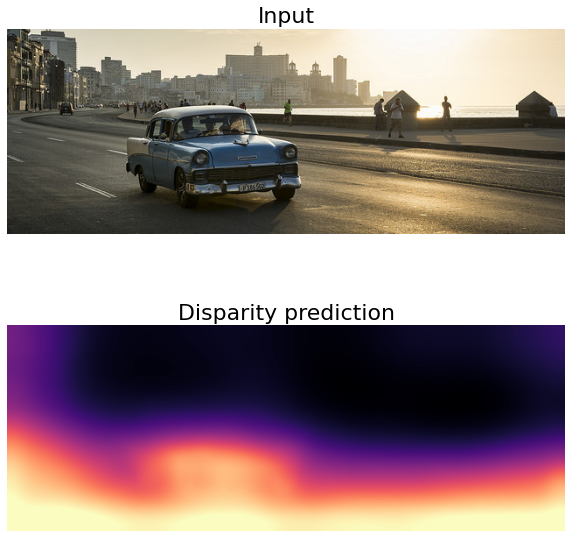

In [23]:
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

================Start evaluate origin=================


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


{'loss/0': tensor(0.1938, device='cuda:0'), 'loss/1': tensor(0.1938, device='cuda:0'), 'loss/2': tensor(0.1937, device='cuda:0'), 'loss/3': tensor(0.1936, device='cuda:0'), 'loss': tensor(0.1937, device='cuda:0')}
{'loss/0': tensor(0.1938, device='cuda:0'), 'loss/1': tensor(0.1938, device='cuda:0'), 'loss/2': tensor(0.1937, device='cuda:0'), 'loss/3': tensor(0.1936, device='cuda:0'), 'loss': tensor(0.1937, device='cuda:0'), 'de/abs_rel': array(0.29237074, dtype=float32), 'de/sq_rel': array(2.0896623, dtype=float32), 'de/rms': array(6.9061494, dtype=float32), 'de/log_rms': array(0.38152838, dtype=float32), 'da/a1': array(0.53636575, dtype=float32), 'da/a2': array(0.7824111, dtype=float32), 'da/a3': array(0.9101813, dtype=float32)}
Result test: Test Loss:  0.19372484 
> start optimize prune encoder
Total conv params: 11166912, Pruned conv params: 10463.0, Pruned ratio: 0.0009369644685648382
================Start evaluate after optimize pruning=================
{'loss/0': tensor(0.1792, d

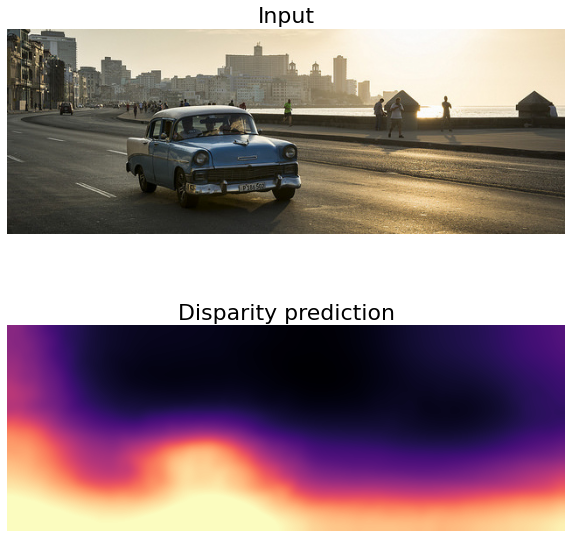

In [ ]:
#trainer.pruning('constant')
trainer.pruning('optimize')
encoder = trainer.models['encoder']
depth_decoder = trainer.models['depth']
encoder.eval()
depth_decoder.eval();
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');

Training model named:
   newmodel/mono_model/models/weights_0
Models and tensorboard events files are saved to:
   newmodel
Training is using:
   cuda


/usr/local/lib/python3.7/dist-packages/torchvision/transforms/transforms.py:288: UserWarning: Argument interpolation should be of type InterpolationMode instead of int. Please, use InterpolationMode enum.
  "Argument interpolation should be of type InterpolationMode instead of int. "


loading model from folder newmodel/mono_model/models/weights_0
Loading encoder weights...
Loading depth weights...
newmodel/mono_model/models/weights_0/adam.pth
Loading Adam weights
Using split:
   eigen_zhou
There are 39810 training items and 4424 validation items

================Start evaluate origin=================


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:4004: UserWarning: Default grid_sample and affine_grid behavior has changed to align_corners=False since 1.3.0. Please specify align_corners=True if the old behavior is desired. See the documentation of grid_sample for details.
  "Default grid_sample and affine_grid behavior has changed "


{'loss/0': tensor(0.1709, device='cuda:0'), 'loss/1': tensor(0.1708, device='cuda:0'), 'loss/2': tensor(0.1707, device='cuda:0'), 'loss/3': tensor(0.1707, device='cuda:0'), 'loss': tensor(0.1708, device='cuda:0')}
{'loss/0': tensor(0.1709, device='cuda:0'), 'loss/1': tensor(0.1708, device='cuda:0'), 'loss/2': tensor(0.1707, device='cuda:0'), 'loss/3': tensor(0.1707, device='cuda:0'), 'loss': tensor(0.1708, device='cuda:0'), 'de/abs_rel': array(0.19713068, dtype=float32), 'de/sq_rel': array(1.3137432, dtype=float32), 'de/rms': array(6.3355923, dtype=float32), 'de/log_rms': array(0.26940307, dtype=float32), 'da/a1': array(0.6600126, dtype=float32), 'da/a2': array(0.9097358, dtype=float32), 'da/a3': array(0.9752102, dtype=float32)}
Result test: Test Loss:  0.17077941 
> start constant prune encoder
Pruning threshold: 0.0012200836790725589
Total conv params: 11166912, Pruned conv params: 3350074.0, Pruned ratio: 0.30000004172325134
================Start evaluate after constant pruning=====

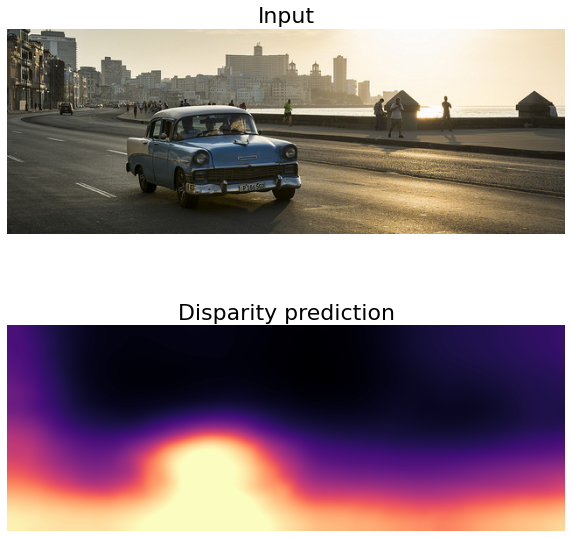

In [ ]:
trainer = Trainer(opts,train_loader,val_loader)
trainer.pruning('constant')
#trainer.pruning('optimize')
encoder = trainer.models['encoder']
depth_decoder = trainer.models['depth']
encoder.eval()
depth_decoder.eval();
with torch.no_grad():
    features = encoder(input_image_pytorch)
    outputs = depth_decoder(features)

disp = outputs[("disp", 0)]
disp_resized = torch.nn.functional.interpolate(disp,
    (original_height, original_width), mode="bilinear", align_corners=False)

# Saving colormapped depth image
disp_resized_np = disp_resized.squeeze().cpu().numpy()
vmax = np.percentile(disp_resized_np, 95)

plt.figure(figsize=(10, 10))
plt.subplot(211)
plt.imshow(input_image)
plt.title("Input", fontsize=22)
plt.axis('off')

plt.subplot(212)
plt.imshow(disp_resized_np, cmap='magma', vmax=vmax)
plt.title("Disparity prediction", fontsize=22)
plt.axis('off');